# Tarea N°2 | Procesamiento de lenguaje natural
### Comparación de Topic Modeling (LDA) y Clustering (KMeans)

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Magister en Data Science, Universidad del Desarrollo</strong><br>
    <em>Profesora: Maria Paz Raveau</em><br>

</div>

*03 de agosto de 2025*

**Nombre estudiante**: Camilo Rivera Verdugo  

-----------

## 1. Descripción

El objetivo de este proyecto es comparar dos técnicas de análisis de textos: **LDA (Latent Dirichlet Allocation)** y **KMeans Clustering**, aplicadas sobre un subset del dataset “El Chile que Queremos”. Se busca evaluar cómo la incorporación de bigramas y el uso de técnicas diferentes de agrupación permiten identificar temáticas relevantes en las opiniones ciudadanas. A través de la creación de una matriz DTM, se ejecutan ambos modelos sobre la misma base de datos, analizando la calidad de los tópicos obtenidos, la segmentación en clusters y la coherencia de cada partición.


In [30]:
# Se importan las librerías necesarias
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import nltk
import stanza
from nltk.tokenize import word_tokenize
import re

## 2. Preparación y preprocesamiento 

En esta sección se realiza la carga del dataset y se ejecuta el preprocesamiento de los textos, que incluye la eliminación de stopwords, la lematización utilizando Stanza y la incorporación de bigramas, . Esto con el objetivo de normalizar el lenguaje y reducir la dimensionalidad del texto, dejando los datos listos para el análisis de tópicos y clustering.


In [31]:
# Descargar stopwords
# nltk.download('stopwords')

esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber','haber','hacer','poder','ir']
esp_stop.remove('estado')
esp_stop.remove('estados')

In [32]:
# Configurar Stanza Pipeline
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2025-08-02 18:40:47 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-08-02 18:40:47 INFO: Downloaded file to /root/stanza_resources/resources.json
2025-08-02 18:40:48 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2025-08-02 18:40:48 INFO: Using device: cuda
2025-08-02 18:40:48 INFO: Loading: tokenize
2025-08-02 18:40:49 INFO: Loading: mwt
2025-08-02 18:40:49 INFO: Loading: pos
2025-08-02 18:40:52 INFO: Loading: lemma
2025-08-02 18:40:53 INFO: Done loading processors!


In [33]:
# Cargar Dataset
df = pd.read_csv('../data/raw/ecqq.csv', sep='\t', index_col=0) 

In [34]:
df.head()

,P2_1_B
0,se necesitan pensiones dignas a los adultos ma...
1,"el acceso a la salud sea de calidad, con diagn..."
2,"conprender que el trabajo es una ""actividad"" y..."
3,"- más especialistas en los consultorios, son e..."
4,hay que poner ojo en la educación de los jóven...


In [ ]:
def lemmatizer(text):
    # Eliminar puntuación antes de lematizar
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in esp_stop]
    return ' '.join(lemmas)


# Aplicar lematización y limpieza
df['lemma'] = [lemmatizer(x) for x in df['P2_1_B']]

In [ ]:
# Tokenización y Bigramas
# Aplicamos bigramas con Gensim y luego los utilizamos tanto para LDA como para KMeans
corpus_tokenizado = [word_tokenize(texto) for texto in df['lemma']]

# Crear bigramas
bigram = Phrases(corpus_tokenizado, min_count=5, threshold=50)
bigram_mod = Phraser(bigram)
textos_bigramas = [bigram_mod[doc] for doc in corpus_tokenizado]

In [ ]:
textos_bigramas[0]

['necesitar',
 'pensión',
 'digno',
 'adulto_mayor',
 'alcanzar',
 'costo',
 'vida',
 'alto',
 'vivir']

Se ve que apareció un bigrama `adulto_mayor`

In [ ]:
# Preparar Corpus y Diccionario para LDA
id2word = gensim.corpora.Dictionary(textos_bigramas)
corpus = [id2word.doc2bow(text) for text in textos_bigramas]

## 3. Diagnóstico y ejecución del modelo LDA

A continucación, se realiza un diagnóstico del número óptimo de tópicos utilizando la métrica de coherencia (Coherence Score). A partir de la matriz DTM generada, se prueba el modelo LDA con distintos valores de tópicos para identificar el punto de mayor coherencia semántica. Finalmente, se ejecuta el modelo LDA con el número de tópicos seleccionado, para posteriormente etiquetar los temas más representativos del corpus.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textos_bigramas, start=2, limit=10, step=1)


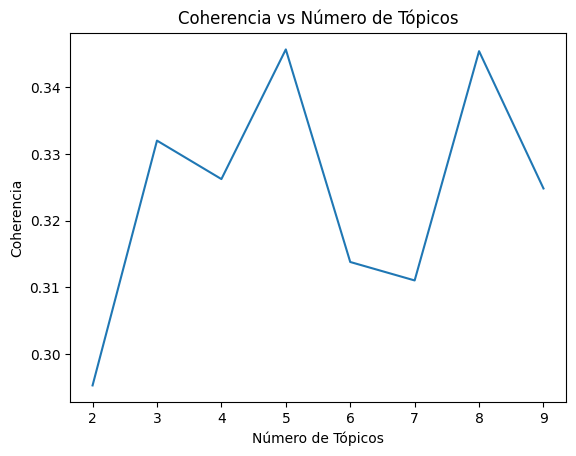

In [ ]:
# Gráfico de Coherencia
plt.plot(range(2, 10), coherence_values)
plt.xlabel("Número de Tópicos")
plt.ylabel("Coherencia")
plt.title("Coherencia vs Número de Tópicos")
plt.show()

**Número óptimo de tópicos: 5**  

El valor más alto de coherencia se da en 5 y 8 tópicos (0.35 aproximadamente). Se seleccionó 5 tópicos como el número óptimo, ya que presenta uno de los valores más altos de coherencia y permite identificar temáticas relevantes sin sobresegmentar el corpus.

### 3.1. Aplicación del modelo LDA

In [ ]:
# Modelo LDA Final
optimal_topics = 5  
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=optimal_topics, random_state=42)

# Mostrar Tópicos y Proponer Etiquetas
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico {idx}: {topic}")

Tópico 0: 0.026*"atención" + 0.020*"educación" + 0.019*"falta" + 0.018*"persona" + 0.016*"medicamento" + 0.016*"mejorar" + 0.015*"calidad" + 0.013*"salud" + 0.013*"especialista" + 0.011*"sistema"
Tópico 1: 0.016*"educación" + 0.015*"país" + 0.012*"agua" + 0.011*"cambio" + 0.009*"existir" + 0.009*"persona" + 0.008*"participante" + 0.008*"afp" + 0.007*"necesidad" + 0.007*"dar"
Tópico 2: 0.027*"sistema" + 0.026*"salud" + 0.026*"pensión" + 0.013*"atención" + 0.012*"calidad" + 0.011*"vida" + 0.010*"sueldo" + 0.010*"público" + 0.010*"mejor" + 0.009*"adulto_mayor"
Tópico 3: 0.046*"salud" + 0.028*"mejorar" + 0.026*"atención" + 0.022*"calidad" + 0.022*"especialista" + 0.020*"falta" + 0.017*"espera" + 0.017*"profesional" + 0.015*"acceso" + 0.014*"lista"
Tópico 4: 0.013*"pensión" + 0.010*"afp" + 0.008*"persona" + 0.008*"mejorar" + 0.007*"aumentar" + 0.007*"sueldo" + 0.007*"edad" + 0.006*"existir" + 0.006*"disminuir" + 0.005*"año"


### 3.2. Etiquetado de tópicos - Modelo LDA

**Tópico 0: “Falta de recursos en salud y educación”**  
- Palabras como “falta”, “atención”, “educación” y “medicamento” reflejan preocupaciones por la escasez de recursos en los sistemas de salud y educación, así como la necesidad de mejorar la calidad de estos servicios.

**Tópico 1: “Reformas estructurales necesarias”**  
- Este tópico agrupa temas como “educación”, “agua”, “cambio” y “afp”, lo que indica una visión de problemáticas estructurales del país, vinculadas a la gestión de recursos naturales y el sistema previsional.

**Tópico 2: “Sistema de pensiones y calidad de vida”**  
- Palabras como “pensión”, “salud”, “sueldo” y “vida” muestran demandas por mejorar el sistema previsional y garantizar condiciones dignas para la población, especialmente en su etapa de jubilación.

**Tópico 3: “Acceso a salud y falta de especialistas”**  
- Este tópico destaca problemas de acceso a la atención médica, como la “falta” de “especialistas”, “listas de espera” y la necesidad de mejorar la calidad de los servicios de salud pública.

**Tópico 4: “Reformas al sistema previsional”**  
- Aparecen palabras como “pensión”, “afp”, “sueldo” y “edad” que indican preocupaciones sobre la insuficiencia de las pensiones actuales y la necesidad de reformar el sistema previsional para mejorar las condiciones de retiro.
----

## 4. Clustering con KMeans

En esta sección se aplica el algoritmo de clustering KMeans sobre la misma matriz DTM utilizada en LDA, con el objetivo de segmentar los documentos en grupos estructurales. A través del gráfico del Silhouette Score se determina el número óptimo de clusters, para luego comparar la calidad de la segmentación obtenida por KMeans frente a la interpretación temática proporcionada por LDA.


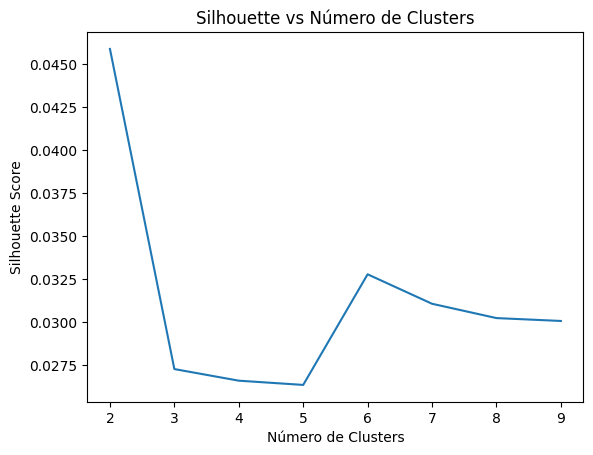

In [38]:
# Convertimos textos_bigramas en strings para la DTM
textos_bigramas_str = [' '.join(doc) for doc in textos_bigramas]

# Clustering con KMeans
vectorizer = CountVectorizer(stop_words=esp_stop)
dtm = vectorizer.fit_transform(textos_bigramas_str)

# Determinar K óptimo usando Silhouette Score
sil = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dtm)
    labels = kmeans.labels_
    sil.append(silhouette_score(dtm, labels))

# Gráfico Silhouette
plt.plot(K, sil)
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs Número de Clusters")
plt.show()

**Número óptimo de clusters: 2**

El valor más alto de Silhouette Score se obtiene con 2 clusters. Sin embargo, el score es bajo (<0.05), indicando que la separación en clusters no es claramente definida. A medida que aumenta el número de clusters, el score disminuye y vuelve a remontar muy bajo en 6, lo que refleja la dificultad de segmentar estos textos de forma organizada.

## 5. Comparación LDA vs KMeans
Para comparar técnicas de agrupación de textos, se aplicó KMeans sobre la misma matriz DTM utilizada en el modelo LDA. El análisis de Silhouette Score mostró que el número óptimo de clusters es `K=2`, sin embargo, el valor del score fue bajo (`0.028`), lo que refleja una segmentación débil y con poca separación clara entre los grupos cuando se intenta segmentar sólo con frecuencia de palabras.

Por otro lado, el modelo LDA permitió identificar 5 tópicos interpretables, aunque algunos de ellos presentan superposición de conceptos, como ocurre con las problemáticas de salud, pensiones y calidad de vida, que generalmente aparecen en la opinión pública. Aún así, LDA logra capturar estas conexiones de manera más coherente y significativa que KMeans, permitiendo entender las temáticas dominantes en el corpus.

En resumen, el número óptimo de clusters (K=2) obtenido con KMeans no coincide con el número de tópicos óptimos (5) en LDA. Además, la partición de LDA tiene mayor sentido interpretativo, ya que trabaja relaciones semánticas entre palabras, mientras que KMeans solo agrupa según patrones de frecuencia, sin contexto temático. Por lo tanto, LDA es más adecuado para el análisis de contenido en este caso.

--------
Referencias
- Gensim LDA: https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_lda.html
- Stanza NLP: https://stanfordnlp.github.io/stanza/
- Scikit-learn: https://scikit-learn.org/stable/modules/clustering.html#k-means